# 349 - Langton's Ant

## Problem Statement

An ant moves on a regular grid of squares that are coloured either black or white.<br> 
The ant is always oriented in one of the cardinal directions (left, right, up or down) and moves from square to adjacent square according to the following rules:<br>
- if it is on a black square, it flips the colour of the square to white, rotates $90$ degrees counterclockwise and moves forward one square.<br>
- if it is on a white square, it flips the colour of the square to black, rotates $90$ degrees clockwise and moves forward one square.<br>

Starting with a grid that is entirely white, how many squares are black after $10^{18}$ moves of the ant?

## Solution

For this kind of problem, we can start by simulating the path taken by the ant and trying to figure a pattern. For the first 50k moves, we will record the following:
- Number of black squares after $i$-th move,
- Position of the ant after $i$-th move.

Let's first get those values and produce some visualisations.

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
coords = defaultdict(int)   # key: coordinate, value: 0 for white, 1 for black
curr_coords = [0, 0]        # current coordinates
blacks = 0                  # total number of black squares
orientation = 'r'           # current orientation

# Map with delta of coordinates and next orientation given current orientation
# For white squares
white_map = {
    'l': ([0, 1], 'u'),
    'r': ([0, -1], 'd'),
    'u': ([1, 0], 'r'),
    'd': ([-1, 0], 'l'),
}

# Map with delta of coordinates and next orientation given current orientation
# For black squares
black_map = {
    'l': ([0, -1], 'd'),
    'r': ([0, 1], 'u'),
    'u': ([-1, 0], 'l'),
    'd': ([1, 0], 'r'),
}

# Lists to keep track of values
coords_list = []
blacks_list = []

# Simulate ant's path
for _ in range(50000):
    coords_list.append(tuple(curr_coords))
    blacks_list.append(blacks)
    x, y = curr_coords
    if coords[tuple(curr_coords)] == 0:
        coords[tuple(curr_coords)] = 1
        blacks += 1
        (dx, dy), orientation = white_map[orientation]
        curr_coords = [x + dx, y + dy]
    else:
        coords[tuple(curr_coords)] = 0
        blacks -= 1
        (dx, dy), orientation = black_map[orientation]
        curr_coords = [x + dx, y + dy]

Let's plot the ant's path and the evolution of the number of black squares.

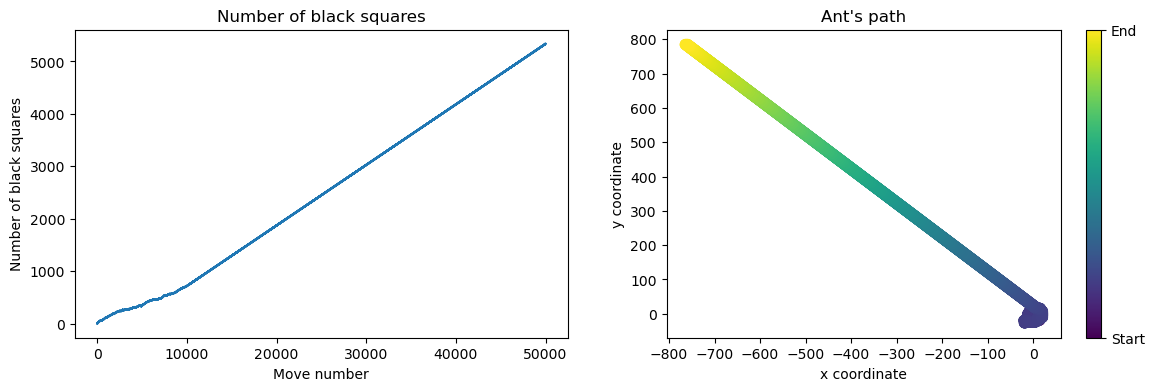

In [3]:

# Extract x and y values from coordinates
x_values = [x[0] for x in coords_list]
y_values = [x[1] for x in coords_list]

# Generate color map
norm = plt.Normalize(0, len(coords_list)-1)
colors = plt.cm.viridis(norm(range(len(coords_list))))

# Figure
fig = plt.figure(figsize=(14, 4))
# Plot number of black squares
ax1 = fig.add_subplot(121)
ax1.plot(range(len(blacks_list)), blacks_list)
ax1.set_xlabel('Move number')
ax1.set_ylabel('Number of black squares')
ax1.set_title('Number of black squares')
# Plot ant's path
ax2 = fig.add_subplot(122)
scatter = ax2.scatter(x_values, y_values, color=colors)
ax2.set_xlabel('x coordinate')
ax2.set_ylabel('y coordinate')
ax2.set_title('Ant\'s path')
# Create a colorbar
cbar = plt.colorbar(scatter)
cbar.set_ticks([norm(0), norm(len(coords_list)-1)])
cbar.set_ticklabels(['Start', 'End'])

The plots above reveal an interesting pattern. For approximately 10k moves, there is not clear pattern. But after this, the ant seems to follow a regular pattern, getting further and further away from the initial points (moving to the north-west assuming it starts looking east). The number of black squares seem to increase linearly. 

let's focus on a smaller number moves. We pick 350 moves stating at move 20000.

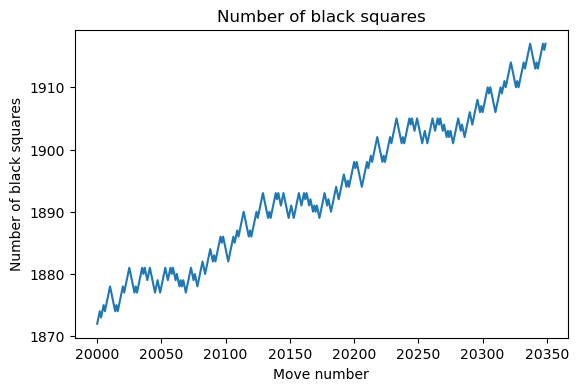

In [4]:
# Figure
fig = plt.figure(figsize=(14, 4))
# Plot number of black squares
ax1 = fig.add_subplot(121)
ax1.plot(range(20000, 20350), blacks_list[20000:20350])
ax1.set_xlabel('Move number')
ax1.set_ylabel('Number of black squares')
ax1.set_title('Number of black squares');

We see that there seems to be a pattern of approximately 100 moves. Let's use a pattern detection algorithm to check if a pattern of length appoximately equal to 100 repeats for the whole series. The algorithm below will find the samllest repeating sequence with length between `min_seq_len` and `max_seq_len`. 

In [5]:
def sequence_repeats(subsequence, lst):
    """Check if a given subsequence repeats in the list, allowing for incomplete
    repetition at the end."""
    n = len(subsequence)
    for i in range(0, len(lst), n):
        # Handle incomplete pattern at the end
        if i + n > len(lst):
            if subsequence[:len(lst)-i] != lst[i:]:
                return False
        else:
            if subsequence != lst[i:i+n]:
                return False
    return True


def find_smallest_repeating_sequence(lst, min_seq_len, max_seq_len):
    smallest_len = float('inf')
    smallest_seq = []
    for seq_len in range(min_seq_len, max_seq_len):  # Iterate through all possible lengths
        for i in range(len(lst) - seq_len + 1):
            current_seq = lst[i:i + seq_len]
            if sequence_repeats(current_seq, lst):
                if seq_len < smallest_len:
                    smallest_len = seq_len
                    smallest_seq = current_seq
                    break  # Found the smallest repeating sequence so far, no need to continue
        if smallest_seq:  # If we've found a sequence, no need to check longer lengths
            break
    return smallest_seq

As we identified a potential pattern of length around 100, we will look for patterns with length between 80 and 120. Also, we know the pattern does not exist in the beginning so we will start at index 20000. Note that we need to apply the pattern detection algorithm on the first difference of our time series (number of black squares keeps increasing, only the difference repeats).

In [6]:
start = 20000
diff = [blacks_list[i] - blacks_list[i - 1] for i in range(1, len(blacks_list))]
pattern = find_smallest_repeating_sequence(diff[start:], 80, 120)

if pattern:
    print(f'Found a repeating pattern of length {len(pattern)}. The pattern sum is {sum(pattern)}.')
else:
    print('No repeating pattern found.')

Found a repeating pattern of length 104. The pattern sum is 12.


We have identified a pattern (of length 104) that is visible from index 20000 to index 50000, we will assume that the pattern will repeat indefinitely. It is now straightforward to obtain the solution to our problem. We first compute how many full sequences of length 104 we have between 20000 and $10^{18}$, multiply this number by 104 and add it to the number of black squares after move 20000. If at the end the pattern does not fit entirely, we figure out the remainder and multiply by the sum of the corresponding values at the beginning of the pattern. The total is the value we are looking for.

In [7]:
quotient, remainder = divmod(10**18 - 20000, len(pattern))
ans = blacks_list[20000] + sum(pattern) * quotient + sum(pattern[:remainder])
ans

115384615384614952

In [8]:
display(Markdown(f'After $10^{{18}}$ moves, there are {ans} black squares in the grid.'))

After $10^{18}$ moves, there are 115384615384614952 black squares in the grid.